# **ViT**

In [ ]:
# Step 1: Uninstall existing libraries
!pip uninstall transformers accelerate -y

# Step 2: Install required libraries
!pip install transformers[torch] accelerate

# Restart the runtime manually via the "Runtime" menu or by running:
import os
os.kill(os.getpid(), 9)

Found existing installation: transformers 4.41.0
Uninstalling transformers-4.41.0:
  Successfully uninstalled transformers-4.41.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 20.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached

In [ ]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from helper_methods import get_train_val, create_dataset_mltclass, show_images, load_and_transform_image, get_test

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import ViTImageProcessor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile

# Unzipping the annotations file
annotations_tar_path = '/content/drive/MyDrive/annotations.tar.gz'
annotations_extract_path = '/content/annotations'
with tarfile.open(annotations_tar_path, 'r:gz') as tar:
    tar.extractall(path=annotations_extract_path)

# Unzipping the images file
images_tar_path = '/content/drive/MyDrive/images.tar.gz'
images_extract_path = '/content/images'
with tarfile.open(images_tar_path, 'r:gz') as tar:
    tar.extractall(path=images_extract_path)

In [ ]:
df_train, df_val = get_train_val(filepath='/content/annotations/annotations/trainval.txt', val_size=0.2)
# C:\\Users\\alexa\\Documents\\Deep Learning\\Project\\datasets\\images\\images\\

X_train, Y_train = create_dataset_mltclass(df_train, base_path='/content/images/images/')
X_val, Y_val = create_dataset_mltclass(df_val, base_path='/content/images/images/')

Y_train = Y_train.long()
Y_val = Y_val.long()


In [ ]:
labels = torch.unique(Y_train)
print(labels)
print(labels.tolist())
from datasets import Dataset

print(type(df_train))
print(type(df_val))
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
print(type(train_dataset))
print(type(val_dataset))
print(train_dataset)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['image_id', 'class_id', 'species', 'breed', '__index_level_0__'],
    num_rows: 2944
})


In [ ]:
import gc
del df_train, df_val
gc.collect()
torch.cuda.empty_cache()


In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
from transformers import ViTForImageClassification
labels = torch.unique(Y_train)
labels = labels.tolist()
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=torch.max(Y_train) + 1,
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

def transform(example_batch):
    #print(example_batch) # Normally we want a tensor of 'pixel_values': tensor and 'labels': AS INPUTS
    # Take a list of PIL images and turn them to pixel values
    #inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    images_tensors = []
    #Y = []
    base_path = "/content/images/images/"
    #print("Example batch: ", example_batch)
    for im_id in example_batch['image_id']:
        #print("APOEL: ", im_id)
        #image_id, species_id = row[0], row[2]
        image_path = f"{base_path}{im_id}.jpg"  # Adjust format as needed
        image_tensor = load_and_transform_image(image_path)
        images_tensors.append(image_tensor)
    #    Y.append(class_id)

    # Stack all tensors to create a single tensor
    inputs = {}
    inputs['pixel_values'] = torch.stack(images_tensors)
    # Don't forget to include the labels!
    #print(example_batch)
    inputs['labels'] = example_batch['class_id']
    #print(inputs)
    return inputs
prepared_df_train = train_dataset.with_transform(transform)
prepared_df_val = val_dataset.with_transform(transform)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)



preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

<ipython-input-9-b236c57bb65a>:37: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

import transformers
import accelerate

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Transformers version: 4.41.1
Accelerate version: 0.30.1


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:

from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/content",
  per_device_train_batch_size=128, # 16
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True, #True
  save_steps=23,
  eval_steps=23,
  logging_steps=10,
  learning_rate=0.001, # 2e-4
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    # <class 'datasets.arrow_dataset.Dataset'> should be given while we give <class 'pandas.core.frame.DataFrame'>
    #train_dataset=prepared_ds["train"],
    train_dataset=prepared_df_train, #df_train, train_dataset

    #eval_dataset=prepared_ds["validation"],
    eval_dataset=prepared_df_val, #df_val, val_dataset
    tokenizer=processor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


Step,Training Loss,Validation Loss,Accuracy
23,2.123100,1.295734,0.826087
46,0.710800,0.586987,0.857337
69,0.328200,0.527236,0.849185
92,0.210600,0.610510,0.832880
115,0.132500,0.649952,0.816576
138,0.098900,0.648662,0.827446
161,0.050700,0.538108,0.862772
184,0.024200,0.433516,0.885870
207,0.020900,0.413480,0.896739
230,0.013400,0.424163,0.892663


***** train metrics *****
  epoch                    =         10.0
  total_flos               = 2125352457GF
  train_loss               =        0.422
  train_runtime            =   0:09:46.78
  train_samples_per_second =       50.171
  train_steps_per_second   =        0.392


In [ ]:
#test data
df_test = get_test(filepath='/content/annotations/annotations/test.txt')
X_test, Y_test = create_dataset_mltclass(df_test, base_path="/content/images/images/")

# Convert Y_test to Long
Y_test = Y_test.long()
test_dataset = Dataset.from_pandas(df_test)
prepared_df_test = test_dataset.with_transform(transform)

In [ ]:
import gc
del df_test, X_test, Y_test, prepared_df_val, X_train, Y_train, train_dataset, val_dataset # , prepared_df_train
gc.collect()
torch.cuda.empty_cache()

In [ ]:
metrics = trainer.evaluate(prepared_df_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.864
  eval_loss               =      0.515
  eval_runtime            = 0:00:41.80
  eval_samples_per_second =     87.762
  eval_steps_per_second   =     10.979


In [ ]:
#lr = 0.001
train_losses = [2.123100, 0.710800, 0.328200, 0.210600, 0.132500, 0.098900, 0.050700, 0.024200, 0.020900, 0.01340]
val_losses = [1.295734, 0.586987, 0.527236, 0.610510, 0.649952, 0.648662, 0.538108, 0.433516, 0.413480, 0.424163]
val_accuracies = [0.826087, 0.857337, 0.849185, 0.832880, 0.816576, 0.827446, 0.862772, 0.885870, 0.896739, 0.892663]
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
train_losses = [2.593500, 1.496700, 0.836600, 0.394400, 0.273200, 0.209500, 0.163300, 0.146400, 0.136200, 0.129800]
val_losses = [2.062820, 1.200548, 0.749444, 0.538310, 0.447560, 0.403021, 0.377661, 0.363401, 0.357158, 0.354743]
val_accuracies = [0.904891, 0.933424, 0.940217,	0.938859, 0.933424, 0.936141, 0.936141, 0.934783, 0.936141, 0.936141]
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


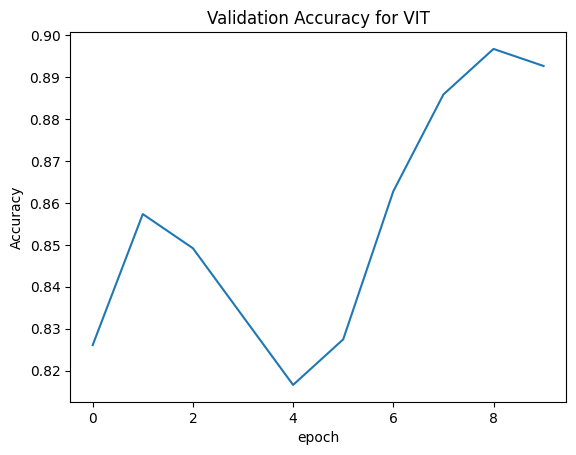

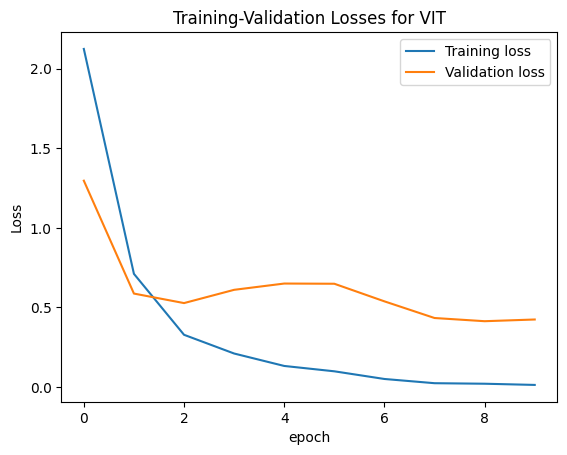

In [ ]:
# Plot our training curves
import matplotlib.pyplot as plt

plt.plot(epochs, val_accuracies)
plt.title('Validation Accuracy for VIT')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
# Display the plot
plt.show()

plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training-Validation Losses for VIT')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
# Display the plot
plt.show()

# **Semi-supervised Learning**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from PIL import Image
from helper_methods import get_train_val_mltclass, get_test, create_dataset_mltclass, show_images, load_and_transform_image
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet34_Weights
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile

# Unzipping the annotations file
annotations_tar_path = '/content/drive/MyDrive/annotations.tar.gz'
annotations_extract_path = '/content/annotations'
with tarfile.open(annotations_tar_path, 'r:gz') as tar:
    tar.extractall(path=annotations_extract_path)

# Unzipping the images file
images_tar_path = '/content/drive/MyDrive/images.tar.gz'
images_extract_path = '/content/images'
with tarfile.open(images_tar_path, 'r:gz') as tar:
    tar.extractall(path=images_extract_path)

In [4]:
df_train, df_val = get_train_val_mltclass(filepath='/content/annotations/annotations/trainval.txt', val_size=0.2)
X_train, Y_train = create_dataset_mltclass(df_train, base_path = "/content/images/images/", augment=True)
X_val, Y_val = create_dataset_mltclass(df_val, base_path="/content/images/images/", augment = False)

# Convert Y_train and Y_val to Long right after their creation
Y_train = Y_train.long()
Y_val = Y_val.long()


#test data
df_test = get_test(filepath='/content/annotations/annotations/test.txt')
X_test, Y_test = create_dataset_mltclass(df_test, base_path="/content/images/images/")

# Convert Y_test to Long
Y_test = Y_test.long()

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        #print("TRAINING DEVIDE: ", device)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    # def validation_step(self, batch):
    #     images, labels = batch
    #     images, labels = images.to(device), labels.to(device)  # Move data to GPU
    #     out = self(images)
    #     with torch.no_grad():
    #         loss = F.cross_entropy(out, labels)
    #         acc = accuracy(out, labels)

    #     return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_step(self, batch):
      images, labels = batch
      #print("VALIDATION DEVICE: ", device)
      images, labels = images.to(device), labels.to(device)  # Move data to GPU
      out = self(images)

      # Compute loss
      loss = F.cross_entropy(out, labels)

      # Compute number of correct predictions
      _, predicted = torch.max(out, 1)
      num_correct = (predicted == labels).sum().item()

      return {'val_loss': loss.detach(), 'num_correct': num_correct}

    def predict(self, images):
      #images, _ = batch
      images = images.to(device)
      out = self(images)
      _, predicted = torch.max(out, 1)
      return predicted


In [6]:
import torch.nn as nn

def set_bn_eval(module):
    """Set BatchNorm layers in evaluation mode."""
    if isinstance(module, nn.BatchNorm2d):
        module.eval()


In [7]:
class DogsCatsCnnModelResNet34(ImageClassificationBase):
    def __init__(self):

        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        #self.network.fc = nn.Linear(num_ftrs, 37)

        self.network.fc = nn.Sequential(
                          nn.Dropout(0.5),
                          nn.Linear(num_ftrs, 37)
                      )

        # Freeze the early layers
        for name, param in self.network.named_parameters():
            if 'layer1' in name or 'layer2' in name or 'layer3' in name:
                param.requires_grad = False

                # Apply the batch normalization adjustment
                if isinstance(param, nn.BatchNorm2d):
                    set_bn_eval(param)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

    def predict(self, images):
      return super().predict(images)

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#@torch.no_grad()
def evaluate(model, X_val, Y_val, batch_size=256):
    with torch.no_grad():
      model.eval()

    loss = 0
    correct = 0
    total_samples = 0
    # Try loadign data into batches
    val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)
    with torch.no_grad():
      for batch in val_loader:
        X_batch, Y_batch = batch
        #X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # Move batch data to the GPU
        outputs = model.validation_step([X_batch, Y_batch])
        loss += outputs['val_loss'].item() * len(batch[0])
        correct += outputs['num_correct']
        total_samples += len(batch[0])

    return {'val_loss': loss / total_samples, 'accuracy': correct / total_samples}
    #batch = [X_val.to(device), Y_val.to(device)]  # Move batch data to the GPU
    #outputs = model.validation_step(batch)
    #return outputs

def fit(model, epochs, lr, X_train, Y_train, X_val, Y_val, batch_size=32, opt_func=torch.optim.SGD):
    history = []
    # optimizer = opt_func(model.parameters(), lr)

    # Filter out the parameters to update to ensure that "Only Unfrozen Parameters Are Passed to the Optimizer"
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = opt_func(params_to_update, lr)

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)


    # Create TensorDataset and DataLoader for training data
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #, num_workers=4

    # Move the model to the GPU
    model = model.to(device)
    #print("MODEL TO DEVICE: ", device)

    for epoch in range(epochs):
        print(f"Epoch: {epoch}")

        # Training Phase
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader):
            X_batch, Y_batch = batch
            #X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # Move batch data to the GPU

            loss = model.training_step([X_batch, Y_batch])
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, X_val, Y_val, batch_size)
        print(f"Epoch {epoch}, result: {result}")
        history.append(result)

        torch.cuda.empty_cache()


    return history

Using device: cuda


In [9]:
# Use 100%, 50%, 10% and 1% of training data
print(X_train.shape)
# 50 %
X_train_half = X_train[:len(X_train) // 2]
Y_train_half = Y_train[:len(Y_train) // 2]
X_unlabeled_half = X_train[len(X_train) // 2:]
Y_unlabeled_half = Y_train[len(Y_train) // 2:]
print(X_train_half.shape)
print(Y_train_half.shape)
print(X_unlabeled_half.shape)
print(Y_unlabeled_half.shape)
# 10 %
X_train_ten = X_train[:len(X_train) // 10]
Y_train_ten = Y_train[:len(Y_train) // 10]
X_unlabeled_ten = X_train[len(X_train) // 10:]
Y_unlabeled_ten = Y_train[len(Y_train) // 10:]
print(X_train_ten.shape)
print(Y_train_ten.shape)
print(X_unlabeled_ten.shape)
print(Y_unlabeled_ten.shape)
# 1 %
X_train_one = X_train[:len(X_train) // 100]
Y_train_one = Y_train[:len(Y_train) // 100]
X_unlabeled_one = X_train[len(X_train) // 100:]
Y_unlabeled_one = Y_train[len(Y_train) // 100:]
print(X_train_one.shape)
print(Y_train_one.shape)
print(X_unlabeled_one.shape)
print(Y_unlabeled_one.shape)


torch.Size([2944, 3, 224, 224])
torch.Size([1472, 3, 224, 224])
torch.Size([1472])
torch.Size([1472, 3, 224, 224])
torch.Size([1472])
torch.Size([294, 3, 224, 224])
torch.Size([294])
torch.Size([2650, 3, 224, 224])
torch.Size([2650])
torch.Size([29, 3, 224, 224])
torch.Size([29])
torch.Size([2915, 3, 224, 224])
torch.Size([2915])


In [10]:
class DogsCatsCnnModelResNet18(ImageClassificationBase):
    def __init__(self):

        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        #self.network.fc = nn.Linear(num_ftrs, 37)

        self.network.fc = nn.Sequential(
                          nn.Dropout(0.5),
                          nn.Linear(num_ftrs, 37)
                      )

        # Freeze the early layers
        for name, param in self.network.named_parameters():
            if 'layer1' in name or 'layer2' in name or 'layer3' in name:
                param.requires_grad = False

                # Apply the batch normalization adjustment
                if isinstance(param, nn.BatchNorm2d):
                    set_bn_eval(param)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

    def predict(self, images):
      return super().predict(images)

In [11]:
# We use ResNet18 as our teacher model
#model_resnet_18_half = DogsCatsCnnModelResNet18().to(device)
model_resnet_18_half_teacher = DogsCatsCnnModelResNet18()
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001
history_half = fit(model_resnet_18_half_teacher, num_epochs, lr, X_train_half, Y_train_half, X_val, Y_val, batch_size, opt_func)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.2MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 0
Epoch 0, result: {'val_loss': 3.0208529596743374, 'accuracy': 0.5584239130434783}
Epoch: 1
Epoch 1, result: {'val_loss': 2.9499097596044126, 'accuracy': 0.6521739130434783}
Epoch: 2
Epoch 2, result: {'val_loss': 2.890383243560791, 'accuracy': 0.7730978260869565}
Epoch: 3
Epoch 3, result: {'val_loss': 2.894255835077037, 'accuracy': 0.7758152173913043}
Epoch: 4
Epoch 4, result: {'val_loss': 2.8979983018792193, 'accuracy': 0.8029891304347826}
Epoch: 5
Epoch 5, result: {'val_loss': 2.904509160829627, 'accuracy': 0.8070652173913043}
Epoch: 6
Epoch 6, result: {'val_loss': 2.9063151712002964, 'accuracy': 0.813858695652174}
Epoch: 7
Epoch 7, result: {'val_loss': 2.9114815566850747, 'accuracy': 0.8260869565217391}
Epoch: 8
Epoch 8, result: {'val_loss': 2.9290839174519414, 'accuracy': 0.8125}
Epoch: 9
Epoch 9, result: {'val_loss': 2.9190464952717656, 'accuracy': 0.8165760869565217}


In [12]:
evaluate_teacher_half = evaluate(model_resnet_18_half_teacher, X_test, Y_test)
print("Evaluation of model trained on the 50% of dataset", evaluate_teacher_half)


Evaluation of model trained on the 50% of dataset {'val_loss': 2.976231125662391, 'accuracy': 0.7743254292722813}


In [13]:
torch.cuda.empty_cache()
# Create TensorDataset and DataLoader for training data
dataset = TensorDataset(X_unlabeled_half, Y_unlabeled_half)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

predictions = []
with torch.no_grad():
  for i, batch in enumerate(data_loader):
        images, _ = batch
        predictions.append(model_resnet_18_half_teacher.predict(images))
#print(predictions)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
flattened_predictions = [prediction.flatten() for prediction in predictions]
Y_unlabeled_half_predictions = torch.cat(flattened_predictions)
print(len(Y_unlabeled_half_predictions))
print(len(Y_unlabeled_half))
#print(Y_unlabeled_half_predictions[1])
#print(Y_unlabeled_half[1])
Y_unlabeled_half = Y_unlabeled_half.to(device)
#print(predictions_flat[1])
#print(Y_unlabeled_half[1])
acc = (Y_unlabeled_half_predictions == Y_unlabeled_half).sum().item() / len(Y_unlabeled_half)
print("Accuracy: ", acc)


1472
1472
Accuracy:  0.6875


In [15]:
# Concatenate the dataset with the pseudo labels so that we can train the student model in the entire dataset


X_train_half_concatenated =  torch.cat((X_train_half, X_unlabeled_half), dim=0)
Y_train_half_concatenated = torch.cat((Y_train_half.to(device), Y_unlabeled_half_predictions), dim=0)

model_resnet_18_half_student = DogsCatsCnnModelResNet18()
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001


In [16]:
device = torch.device("cuda")
print("Using device:", device)
fit(model_resnet_18_half_student, num_epochs, lr, X_train_half_concatenated, Y_train_half_concatenated, X_val, Y_val, batch_size, opt_func)


Using device: cuda
Epoch: 0
Epoch 0, result: {'val_loss': 2.9332734812860903, 'accuracy': 0.6453804347826086}
Epoch: 1
Epoch 1, result: {'val_loss': 2.8289503843887993, 'accuracy': 0.779891304347826}
Epoch: 2
Epoch 2, result: {'val_loss': 2.8502312328504478, 'accuracy': 0.7785326086956522}
Epoch: 3
Epoch 3, result: {'val_loss': 2.8454841012540073, 'accuracy': 0.8043478260869565}
Epoch: 4
Epoch 4, result: {'val_loss': 2.8385265184485395, 'accuracy': 0.8002717391304348}
Epoch: 5
Epoch 5, result: {'val_loss': 2.854140095088793, 'accuracy': 0.7975543478260869}
Epoch: 6
Epoch 6, result: {'val_loss': 2.839310936305834, 'accuracy': 0.8165760869565217}
Epoch: 7
Epoch 7, result: {'val_loss': 2.8548117098600967, 'accuracy': 0.8410326086956522}
Epoch: 8
Epoch 8, result: {'val_loss': 2.8504902694536294, 'accuracy': 0.8491847826086957}
Epoch: 9
Epoch 9, result: {'val_loss': 2.852610681367957, 'accuracy': 0.8519021739130435}


[{'val_loss': 2.9332734812860903, 'accuracy': 0.6453804347826086},
 {'val_loss': 2.8289503843887993, 'accuracy': 0.779891304347826},
 {'val_loss': 2.8502312328504478, 'accuracy': 0.7785326086956522},
 {'val_loss': 2.8454841012540073, 'accuracy': 0.8043478260869565},
 {'val_loss': 2.8385265184485395, 'accuracy': 0.8002717391304348},
 {'val_loss': 2.854140095088793, 'accuracy': 0.7975543478260869},
 {'val_loss': 2.839310936305834, 'accuracy': 0.8165760869565217},
 {'val_loss': 2.8548117098600967, 'accuracy': 0.8410326086956522},
 {'val_loss': 2.8504902694536294, 'accuracy': 0.8491847826086957},
 {'val_loss': 2.852610681367957, 'accuracy': 0.8519021739130435}]

In [17]:
evaluate_student_half = evaluate(model_resnet_18_half_student, X_test, Y_test)
print("Evaluation of model trained on the 50% of dataset", evaluate_student_half)

Evaluation of model trained on the 50% of dataset {'val_loss': 2.9114589610584556, 'accuracy': 0.7964022894521668}


In [18]:
import gc
# Delete variables
del evaluate_student_half, model_resnet_18_half_student, X_train_half_concatenated, Y_train_half_concatenated
del X_train_half, X_unlabeled_half, Y_train_half, Y_unlabeled_half, Y_unlabeled_half_predictions, flattened_predictions
del model_resnet_18_half_teacher, X_train, Y_train
# Run garbage collection
gc.collect()

torch.cuda.empty_cache()


In [19]:
model_resnet_18_ten_teacher = DogsCatsCnnModelResNet18()
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001
fit(model_resnet_18_ten_teacher, num_epochs, lr, X_train_ten, Y_train_ten, X_val, Y_val, batch_size, opt_func)

evaluate_teacher_ten = evaluate(model_resnet_18_ten_teacher, X_test, Y_test)
print("Evaluation of model trained on the 10% of dataset", evaluate_teacher_ten)


torch.cuda.empty_cache()
# Create TensorDataset and DataLoader for training data
dataset = TensorDataset(X_unlabeled_ten, Y_unlabeled_ten)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4) #, num_workers=4

predictions = []
with torch.no_grad():
  for i, batch in enumerate(data_loader):
        images, _ = batch
        predictions.append(model_resnet_18_ten_teacher.predict(images))
#print(predictions)

flattened_predictions = [prediction.flatten() for prediction in predictions]
Y_unlabeled_ten_predictions = torch.cat(flattened_predictions)
print(len(Y_unlabeled_ten_predictions))
print(len(Y_unlabeled_ten))

Y_unlabeled_ten = Y_unlabeled_ten.to(device)
#print(predictions_flat[1])
#print(Y_unlabeled_half[1])
acc = (Y_unlabeled_ten_predictions == Y_unlabeled_ten).sum().item() / len(Y_unlabeled_ten)
print("Accuracy: ", acc)


Epoch: 0
Epoch 0, result: {'val_loss': 3.3459545944048013, 'accuracy': 0.28804347826086957}
Epoch: 1
Epoch 1, result: {'val_loss': 3.2196888612664263, 'accuracy': 0.3111413043478261}
Epoch: 2
Epoch 2, result: {'val_loss': 3.147295381711877, 'accuracy': 0.3654891304347826}
Epoch: 3
Epoch 3, result: {'val_loss': 3.135014772415161, 'accuracy': 0.4361413043478261}
Epoch: 4
Epoch 4, result: {'val_loss': 3.141985167627749, 'accuracy': 0.46467391304347827}
Epoch: 5
Epoch 5, result: {'val_loss': 3.140621672505918, 'accuracy': 0.4796195652173913}
Epoch: 6
Epoch 6, result: {'val_loss': 3.1615531755530317, 'accuracy': 0.49592391304347827}
Epoch: 7
Epoch 7, result: {'val_loss': 3.1929068047067393, 'accuracy': 0.49184782608695654}
Epoch: 8
Epoch 8, result: {'val_loss': 3.2190394401550293, 'accuracy': 0.49728260869565216}
Epoch: 9
Epoch 9, result: {'val_loss': 3.2278668880462646, 'accuracy': 0.53125}
Evaluation of model trained on the 10% of dataset {'val_loss': 3.2499919402303665, 'accuracy': 0.479

In [20]:
# Concatenate the dataset with the pseudo labels so that we can train the student model in the entire dataset

X_train_ten_concatenated =  torch.cat((X_train_ten, X_unlabeled_ten), dim=0)
Y_train_ten_concatenated = torch.cat((Y_train_ten.to(device), Y_unlabeled_ten_predictions), dim=0)

model_resnet_18_ten_student = DogsCatsCnnModelResNet18()
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001
fit(model_resnet_18_ten_student, num_epochs, lr, X_train_ten_concatenated, Y_train_ten_concatenated, X_val, Y_val, batch_size, opt_func)

evaluate_student_ten= evaluate(model_resnet_18_ten_student, X_test, Y_test)
print("Evaluation of model trained on the 10% of dataset", evaluate_student_ten)

Epoch: 0
Epoch 0, result: {'val_loss': 3.178751551586649, 'accuracy': 0.3016304347826087}
Epoch: 1
Epoch 1, result: {'val_loss': 3.080195157424263, 'accuracy': 0.41847826086956524}
Epoch: 2
Epoch 2, result: {'val_loss': 3.1132408328678296, 'accuracy': 0.45516304347826086}
Epoch: 3
Epoch 3, result: {'val_loss': 3.084619024525518, 'accuracy': 0.49184782608695654}
Epoch: 4
Epoch 4, result: {'val_loss': 3.105363420818163, 'accuracy': 0.5081521739130435}
Epoch: 5
Epoch 5, result: {'val_loss': 3.1113410617994224, 'accuracy': 0.5040760869565217}
Epoch: 6
Epoch 6, result: {'val_loss': 3.129466668419216, 'accuracy': 0.5040760869565217}
Epoch: 7
Epoch 7, result: {'val_loss': 3.1422657862953516, 'accuracy': 0.5054347826086957}
Epoch: 8
Epoch 8, result: {'val_loss': 3.1332416845404585, 'accuracy': 0.5217391304347826}
Epoch: 9
Epoch 9, result: {'val_loss': 3.1508265681888745, 'accuracy': 0.5163043478260869}
Evaluation of model trained on the 10% of dataset {'val_loss': 3.2022756207830803, 'accuracy

In [21]:
import gc
# Delete variables
del evaluate_student_ten, model_resnet_18_ten_student, X_train_ten_concatenated, Y_train_ten_concatenated
del X_train_ten, X_unlabeled_ten, Y_train_ten, Y_unlabeled_ten, Y_unlabeled_ten_predictions, flattened_predictions
del model_resnet_18_ten_teacher
# Run garbage collection
gc.collect()

torch.cuda.empty_cache()

In [22]:
model_resnet_18_one_teacher = DogsCatsCnnModelResNet18()
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001
fit(model_resnet_18_one_teacher, num_epochs, lr, X_train_one, Y_train_one, X_val, Y_val, batch_size, opt_func)

evaluate_teacher_one = evaluate(model_resnet_18_one_teacher, X_test, Y_test)
print("Evaluation of model trained on the 1% of dataset", evaluate_teacher_one)


torch.cuda.empty_cache()
# Create TensorDataset and DataLoader for training data
dataset = TensorDataset(X_unlabeled_one, Y_unlabeled_one)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4) #, num_workers=4

predictions = []
with torch.no_grad():
  for i, batch in enumerate(data_loader):
        images, _ = batch
        predictions.append(model_resnet_18_one_teacher.predict(images))
#print(predictions)

flattened_predictions = [prediction.flatten() for prediction in predictions]
Y_unlabeled_one_predictions = torch.cat(flattened_predictions)
print(len(Y_unlabeled_one_predictions))
print(len(Y_unlabeled_one))

Y_unlabeled_one = Y_unlabeled_one.to(device)
#print(predictions_flat[1])
#print(Y_unlabeled_half[1])
acc = (Y_unlabeled_one_predictions == Y_unlabeled_one).sum().item() / len(Y_unlabeled_one)
print("Accuracy: ", acc)
# Concatenate the dataset with the pseudo labels so that we can train the student model in the entire dataset

X_train_one_concatenated =  torch.cat((X_train_one, X_unlabeled_one), dim=0)
Y_train_one_concatenated = torch.cat((Y_train_one.to(device), Y_unlabeled_one_predictions), dim=0)

model_resnet_18_one_student = DogsCatsCnnModelResNet18()
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 256
lr = 0.001
fit(model_resnet_18_one_student, num_epochs, lr, X_train_one_concatenated, Y_train_one_concatenated, X_val, Y_val, batch_size, opt_func)

evaluate_student_one= evaluate(model_resnet_18_one_student, X_test, Y_test)
print("Evaluation of model trained on the 1% of dataset", evaluate_student_one)

Epoch: 0
Epoch 0, result: {'val_loss': 3.5408510747163193, 'accuracy': 0.09239130434782608}
Epoch: 1
Epoch 1, result: {'val_loss': 3.5033055906710415, 'accuracy': 0.13722826086956522}
Epoch: 2
Epoch 2, result: {'val_loss': 3.48703816662664, 'accuracy': 0.13994565217391305}
Epoch: 3
Epoch 3, result: {'val_loss': 3.4778496182483174, 'accuracy': 0.14402173913043478}
Epoch: 4
Epoch 4, result: {'val_loss': 3.4731814342996348, 'accuracy': 0.14673913043478262}
Epoch: 5
Epoch 5, result: {'val_loss': 3.4731379488240117, 'accuracy': 0.15081521739130435}
Epoch: 6
Epoch 6, result: {'val_loss': 3.4776234315789263, 'accuracy': 0.15081521739130435}
Epoch: 7
Epoch 7, result: {'val_loss': 3.4825170040130615, 'accuracy': 0.1480978260869565}
Epoch: 8
Epoch 8, result: {'val_loss': 3.488100881161897, 'accuracy': 0.14673913043478262}
Epoch: 9
Epoch 9, result: {'val_loss': 3.4937552472819453, 'accuracy': 0.14673913043478262}
Evaluation of model trained on the 1% of dataset {'val_loss': 3.4994693408060478, 'a

In [23]:
import gc
# Delete variables
del evaluate_student_one, model_resnet_18_one_student, X_train_one_concatenated, Y_train_one_concatenated
del X_train_one, X_unlabeled_one, Y_train_one, Y_unlabeled_one, Y_unlabeled_one_predictions, flattened_predictions
del model_resnet_18_one_teacher
# Run garbage collection
gc.collect()

torch.cuda.empty_cache()

PLOTS


In [2]:
import numpy as np
accuracies_teacher_50 = [0.6127717391304348, 0.626358695652174, 0.7703804347826086, 0.8029891304347826, 0.7934782608695652, 0.8152173913043478, 0.8288043478260869, 0.8464673913043478, 0.8179347826086957, 0.8220108695652174]

accuracies_student_50 = [0.6766304347826086, 0.7676630434782609, 0.7975543478260869, 0.7880434782608695, 0.8247282608695652, 0.8125, 0.8165760869565217, 0.8043478260869565, 0.8206521739130435, 0.8125]

accuracies_teacher_10 = [0.2595108695652174, 0.35190217391304346, 0.40353260869565216, 0.4673913043478261, 0.5, 0.5108695652173914, 0.5461956521739131, 0.5570652173913043, 0.5570652173913043, 0.5625]

accuracies_student_10 = [0.3953804347826087, 0.4904891304347826, 0.5271739130434783, 0.5244565217391305, 0.5543478260869565, 0.5760869565217391, 0.5543478260869565, 0.5747282608695652, 0.5855978260869565, 0.592391304347826]

accuracies_teacher_1 = [0.12364130434782608, 0.16576086956521738, 0.1793478260869565, 0.17798913043478262, 0.18342391304347827, 0.17119565217391305, 0.17255434782608695, 0.17119565217391305, 0.16847826086956522, 0.16983695652173914]

accuracies_student_1 = [0.08831521739130435, 0.10597826086956522, 0.11820652173913043, 0.12364130434782608, 0.12771739130434784, 0.11820652173913043, 0.12907608695652173, 0.13722826086956522, 0.11684782608695653, 0.12228260869565218]

epochs = np.arange(10)

In [5]:
def plot_data(x, y1, y2, title):
  plt.plot(x, y1, label='teacher')
  plt.plot(x, y2, label='student')
  # Adding title and labels
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

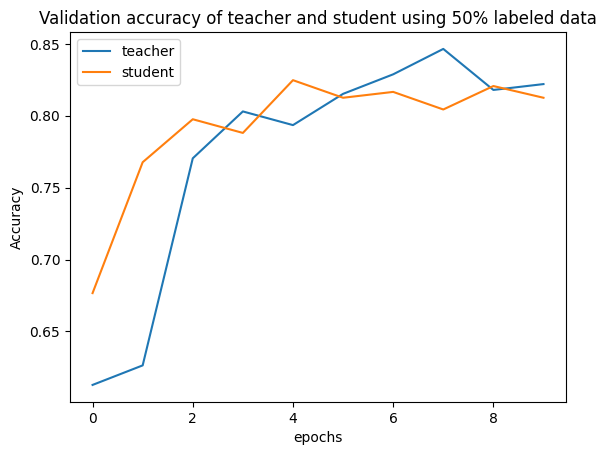

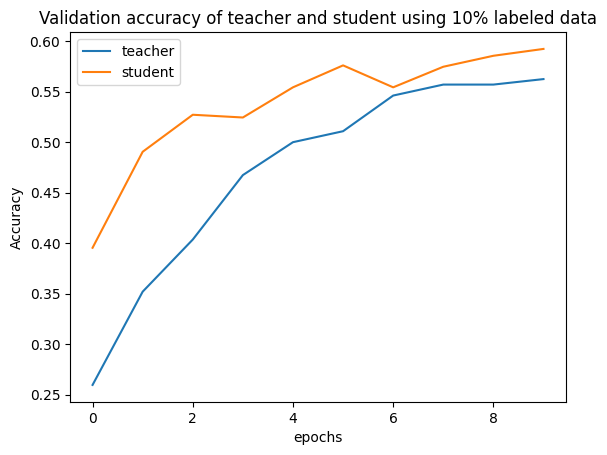

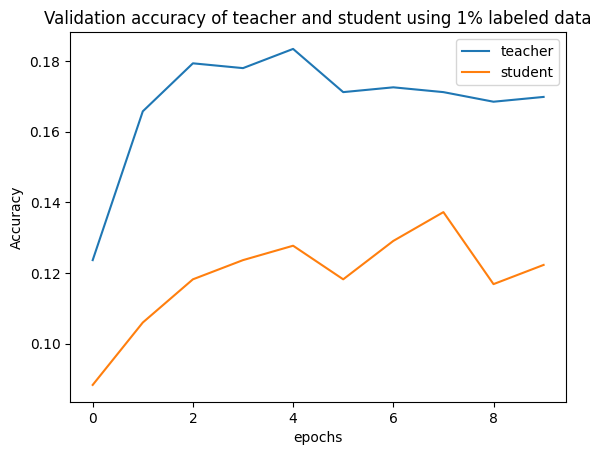

In [7]:
import matplotlib.pyplot as plt
plot_data(epochs, accuracies_teacher_50, accuracies_student_50, 'Validation accuracy of teacher and student using 50% labeled data')
plot_data(epochs, accuracies_teacher_10, accuracies_student_10, 'Validation accuracy of teacher and student using 10% labeled data')
plot_data(epochs, accuracies_teacher_1, accuracies_student_1, 'Validation accuracy of teacher and student using 1% labeled data')
